### Notebook för att utforska vilken modell som är bäst att använda för att prediktera taxipriser

För att i det riktiga programmet använda en väl lämpad modell behöver jag först utvärdera olika alternativ och se hur bra de presterar på min data.   

Jag gör dessa tester i en notebook för att på ett enkelt sätt kunna testa flera modeller och jämföra deras resultat.   

Eftersom uppgiften gäller att prediktera ett kontinuerligt värde (pris) är linjär regression en naturlig kandidat. Samtidigt kan jag testa andra modeller, som t.ex. KNN, för att se om de eventuellt ger bättre resultat på just denna data. Logistisk regression är däremot inte lika relevant här eftersom den främst används för klassificeringsproblem (t.ex. ja/nej-frågor).   

In [25]:
from taxipred.utils.constants import TAXI_CSV_PATH
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(TAXI_CSV_PATH)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       778 non-null    float64
 1   Time_of_Day            778 non-null    object 
 2   Day_of_Week            778 non-null    object 
 3   Passenger_Count        778 non-null    float64
 4   Traffic_Conditions     778 non-null    object 
 5   Weather                778 non-null    object 
 6   Base_Fare              778 non-null    float64
 7   Per_Km_Rate            778 non-null    float64
 8   Per_Minute_Rate        778 non-null    float64
 9   Trip_Duration_Minutes  778 non-null    float64
 10  Trip_Price             778 non-null    float64
dtypes: float64(7), object(4)
memory usage: 67.0+ KB


##### Delar upp datan i train | test

In [4]:
X = df.drop(columns=["Trip_Price"]) #tar bort alla kolumner förutom den som ska vara y.
y = df["Trip_Price"]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((544, 10), (234, 10), (544,), (234,))

##### Eftersom mitt dataset innehåller både numeriska och kategoriska kolumner behöver jag särskilja dessa och hantera dem på olika sätt.   
StandardScaler gör att features får medelvärde 0 och standardavvikelse 1.   
OneHotEncoder gör så att modellerna kan hantera textvaiabler. 


In [6]:
# 1) Dela upp kolumner
num_cols = X_train.select_dtypes(include="number").columns
cat_cols = X_train.select_dtypes(exclude="number").columns
#

# Skala numeriska
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_cols])
X_test_num  = scaler.transform(X_test[num_cols])


# 3) One-hot-koda kategoriska
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_cols])
X_test_cat  = encoder.transform(X_test[cat_cols])


# 4) Slå ihop till en enda feature-matris
import numpy as np
X_train_prepared = np.hstack([X_train_num, X_train_cat])
X_test_prepared  = np.hstack([X_test_num, X_test_cat])


In [10]:
model = LinearRegression()
model.fit(X_train_prepared, y_train)
y_pred = model.predict(X_test_prepared)

In [11]:
model.coef_

array([36.66371503,  0.36679852,  1.51516123, 10.59317153,  6.59979555,
       10.21894227,  0.43257082, -1.03345688, -0.12066615,  0.7215522 ,
        0.43849313, -0.369581  , -0.06891213,  1.15454986, -2.19191935,
       -0.83454461,  1.8719141 , -0.15008829, -0.83710837,  1.80041804,
       -0.81322138])

### Prediktion

In [15]:
test_sample_features = X_test_prepared[0].reshape(1, -1)
test_sample_target = y_test.values[0]

print("Test sample features: ", test_sample_features)
print("Test sample target: ", test_sample_target)

Test sample features:  [[ 0.84611398 -1.40147905  1.15924198  0.83001055  0.48902436  1.04244211
   0.          0.          1.          0.          0.          0.
   1.          0.          1.          0.          0.          1.
   0.          0.          0.        ]]
Test sample target:  108.2325


In [16]:
model.predict(test_sample_features)

array([110.17021529])

In [17]:
test_sample_target

np.float64(108.2325)

##### Prediktion av testdatan

In [18]:
y_pred = model.predict(X_test_prepared)
y_pred.shape

(234,)

In [20]:
y_pred[:5]


array([110.17021529,  77.39803316,  26.47614327,  51.99699327,
       100.66154628])

In [22]:
y_test[:5].values

array([108.2325,  73.5544,  32.2622,  38.4514, 102.4302])

### Evaluering

In [26]:

print("MSE:", mean_squared_error(y_test, y_pred))
print("MAE: ", mean_absolute_error(y_test, y_pred))
print("RMSE: ", root_mean_squared_error(y_test, y_pred))
print("R2 :", r2_score(y_test, y_pred))

MSE: 226.81751579226025
MAE:  9.505027649510083
RMSE:  15.060462004608631
R2 : 0.8463709689648986


In [29]:
errors = y_pred - y_test.values
biggest_errors_idx = np.argsort(abs(errors))[-10:]
df.iloc[biggest_errors_idx]

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
50,49.36,Morning,Unknown,4.0,High,Rain,4.92,1.13,0.12,36.56,65.0840
123,12.86,Evening,Weekday,1.0,Low,Clear,2.39,1.13,0.40,56.62,39.5698
24,48.32,Morning,Weekday,2.0,Low,Clear,2.49,0.61,0.44,67.25,61.5552
36,47.04,Night,Weekday,4.0,Medium,Unknown,4.83,1.38,0.36,79.54,98.3796
128,32.04,Afternoon,Weekday,4.0,Low,Clear,4.44,1.02,0.41,9.10,40.8518
176,39.95,Evening,Weekend,3.0,Low,Clear,4.46,1.19,0.31,25.25,59.8280
193,15.43,Evening,Weekday,2.0,High,Clear,2.73,0.93,0.16,75.12,29.0991
30,2.69,Afternoon,Weekday,4.0,Low,Clear,4.60,1.95,0.34,97.49,42.9921
92,27.43,Morning,Weekend,4.0,Low,Rain,2.58,1.59,0.28,23.53,52.7821
136,26.09,Afternoon,Weekday,4.0,Medium,Rain,3.92,0.87,0.45,62.23,54.6218


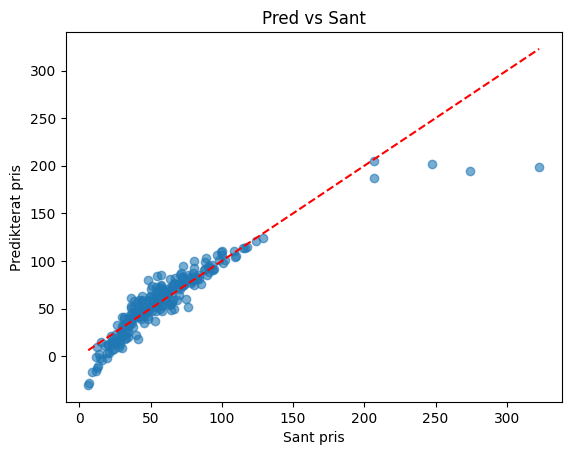

In [27]:

plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Sant pris")
plt.ylabel("Predikterat pris")
plt.title("Pred vs Sant")
plt.show()